# Analysis of model results
To do:
* implement, test/check multi-label computations
* use threshold at breakeven point to generate labels
* write labels to geotiffs to dir data/test/predict_process or so 
* implement masks for selecting no_img pixels


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from keras.models import load_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

from src.data import utils
from src.models.data import *
from src.models.model import *
from src.models.predict_model import *

from src.visualization.visualize import *

from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc, auc_pr, auc_pr_multiclass

import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
def categoricalCrossentropy(y_true, y_pred, the0, the1):
    '''
    Calculate the class-weighted categorical cross-entropy for the given
    predicted and true sets.

    y_true [in] The truth set to test against. This is a Tensor with a last
                dimension that contains a set of 1-of-N selections.
    y_pred [in] The predicted set to test against. This is a Tensor with a last
                dimension that contains a set of 1-of-N selections.
    returns     A Tensor function that will calculate the weighted categorical
                cross-entropy on the inputs.
    '''

    P = np.array([[1, the1, the1], 
                  [the0, 1, the1], 
                  [the1, the0, 1]])
    P = np.array([[1, 0, 0], 
                  [0, 1, the0], 
                  [the1, 0, 1]])
    P = np.array([[1-the0, the0, 0], 
                  [the1, 1-the0 - the1, the0], 
                  [the1, 0, 1-the1]])#noinv
    P = np.array([[1, the0, the0], 
                  [the1, 1, (the0+the1)*.5], 
                  [the1, (the0+the1)*.5, 1]])#noinv
    P = P#/np.linalg.norm(P)

    P_inv = K.constant(np.linalg.inv(P))
    # If weights are defined, multiply the truth values by the class weights.
    #
    if P_inv is not None:
        # Wrap the loss weights in a tensor object.
        #
        pp =  np.linalg.inv(P)
        theWeights =  K.constant(pp, shape=pp.shape)

        y_true = K.dot(y_true,theWeights)

    # Get the cross-entropy and return it.
    #
    crossEntropy = K.categorical_crossentropy(y_true, y_pred)

    return crossEntropy

def noisy_loss(the0, the1):    
    def loss(y_true, y_pred):
        return categoricalCrossentropy(y_true, y_pred, the0, the1)
    return loss

In [8]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
#sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directory with data (image tiles) to be analyzed
dir_eval = "../../data/test"
# subdirs
dir_x = 'sat'
dir_y = 'map'

# image size in pixels
target_size = (256, 256)
# resolution
pixels_per_meter = 1.0/3.125


# max. number of samples (files) to analyze (predicition takes a long time)
max_num_x = 98

# ------------- selection of samples to plot in detail -----------------------------
if True:
    # set *number* of samples (files) to analyze in detail and choose among
    # 'random' and 'head_tail'
    num_x_show = 98
    mode_sample_choice = None#"random"
else:
    # inverse: select specific samples (these MUST be within the set of files analyzed)
    file_list_selected = ["20180504_094435_0e19_3B_0472.tif"]
    num_x_show = len(file_list_selected)
    mode_sample_choice = None

# display of results of individual samples: either "full" or "compact"
samples_display_mode = "compact"
# directory in which to save graphics files
dir_figures = "../../reports/figures"
# out output format of figures - set to None to skip (filenames will be given automatically 
# according to underlying model and tile names)
format_figures = "png"


# ----------------- selection of model to analyze -----------------------------
if True:
    # path to & filename of model to analyze
    trained_model_fn = '../../models/red_ds_multicat_unet_NL_th0-0.01_th1-0.08_th2-0.08_bs-3_ep-15_r-7.hdf5'
    #trained_model_fn = '../../models/models_segnet_06_12_24_00.hdf5'
    # framework underlying model
    type_model = 'keras'
else:
    trained_model_fn = '../../models/RandomForest_binary.pkl'
    trained_model_fn = '../../models/RandomForest_multiclass.pkl'
    # framework underlying model
    type_model = 'scikit'

# Keras models: list any custom loss or metric functions of the model here
custom_objects = {'accuracy': 'accuracy', 'auc_pr_multiclass': auc_pr_multiclass, 'loss': noisy_loss(0.01, 0.08)}

### Load model

In [9]:
if type_model == "keras":
    # The additional input arg "custom_objects" is needed if custom loss or metrics were used in the model
    model = load_model(trained_model_fn, custom_objects=custom_objects)
    # based on the output of the last layer, find out whether the model is binary or multiclass
    model_is_binary = model.get_layer(None,-1).output_shape[3] == 1
    num_classes = max(2, model.get_layer(None,-1).output_shape[3])
    # infer width, height and number of features (= bands in satellite images) from input layer
    input_layer = model.get_layer(None,0).output_shape
    # size of images
    sz = input_layer[1:3]
    num_features = input_layer[3]
    assert(sz == target_size), "nonmatching image tile sizes"
elif type_model == "scikit":
    model = joblib.load(trained_model_fn)
    model_is_binary = model.n_classes_ == 2
    num_classes = model.n_classes_
    num_features = model.n_features_    

print("{0:d} features, {1:d} classes".format(num_features, num_classes))

4 features, 3 classes


### Some preparatory computations

In [10]:
# obtain list and number of available samples (files)
file_list_x, num_x = utils.get_list_samplefiles(os.path.join(dir_eval, dir_x))

# actual number of samples that will be analyzed, given samples available and user's choice
num_x_use = min(num_x, max_num_x)

# actual number of samples to be *plotted*, given number of samples to be analyzed
num_x_show = min(num_x_show, num_x_use)

### Loop over files, collecting data & predicitions (takes a long time)

In [11]:
# **********************************************************************************************
# CLASS_DICT is central to everything that follows: it maps values in the label files to classes
# (no road, paved road, etc.) and also defines new classes (no_img) which are needed
# for evaluation metrics. If the values in this dict do not match the label values used during
# training, the code will not work or produce nonsense.
# **********************************************************************************************
CLASS_DICT = get_class_dict("all_legal")

# similarly, CLASS_PLOT_PROP defines colors for the different classes
CLASS_PLOT_PROP = get_class_plot_prop()

# number of pixels per image
img_size = np.prod(target_size)

# if it is a binary model, the score prediction matrix is 2D, otherwise it has as many layers 
# (or slices, if you want) as there are classes
if model_is_binary:
    dim_yscore = 1
    class_dict = get_class_dict("binary")
    # the following lines are needed to extract the correct column out of the prediction score 
    # from a Scikit-learn model
    tmp_dict = class_dict.copy()
    del tmp_dict["no_img"]
    yscore_ix = get_sorted_key_index("any_road", tmp_dict)
else:
    dim_yscore = num_classes
    class_dict = get_class_dict("multiclass")


# preallocate arrays collecting the label (y) values and y scores of all 
# all pixels of all tiles
arr_y = np.empty((img_size * num_x_use, 1), dtype=np.uint8)
arr_yscore = np.empty((img_size * num_x_use, dim_yscore), dtype=np.float32)

# array collecting the key metric for each sample (image tile) individually; 
# useful for a sorted display of individual tiles
arr_metric = np.empty(num_x_use)

# loop over tiles up to num_x_use)
for i, fn in enumerate(file_list_x[:num_x_use]):
    # read sat image tile
    x = io.imread(os.path.join(dir_eval, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(dir_eval, dir_y, fn))
    # refactor labels according to model
    y, mask = refactor_labels(x, y, class_dict=CLASS_DICT, model_is_binary=model_is_binary, meta=None)
    # scale x
    x = x/255.0
    # copy reshaped labels in array
    y_reshaped = y.reshape((img_size, 1))
    arr_y[i*img_size:(i+1)*img_size,:] = y_reshaped
    # predict
    if (100*np.sum(mask)/img_size) > 25:
        pass
    else:
        print("analyzing {0:s} ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
        if type_model == "keras":
            # in the case of a binary classification, yscore is a (target_size) array (no third dim)
            # in the case of multiclass classification, yscore is a (target_size) by (num_classes) array
            yscore = model.predict(x.reshape((1,) + target_size +(4,)))
            # reshape for storage and analysis
            yscore_reshaped = yscore.reshape((img_size, dim_yscore), order = 'C')
        elif type_model == "scikit":
            # yscore is always a (img_size) by (num_classes) array
            yscore = model.predict_proba(x.reshape((img_size, num_features), order = 'C'))
            if model_is_binary:
                # in contrast to keras' .predict most of scikit-learn's predict_proba methods put out one column per class
                # also for binarry classification, so pick only one layer: in a binary classification, p(class 1) = 1-p(class 2)
                yscore_reshaped = yscore[:,yscore_ix].reshape((img_size, dim_yscore))
            else:
                yscore_reshaped = yscore
        # copy reshaped prediction in array
        arr_yscore[i*img_size:(i+1)*img_size,:] = yscore_reshaped
        # compute and store metric used for sorting
        _, _, roc_auc_dict, _, _, pr_auc_dict, _, _, _ = multiclass_roc_pr(y_reshaped, yscore_reshaped, class_dict=class_dict)

        if len(pr_auc_dict) == 0:
            arr_metric[i] = None
        elif len(pr_auc_dict) == 1:
            # binary labels
            arr_metric[i] = pr_auc_dict[list(pr_auc_dict.keys())[0]]
        else:
            # pick score of union of roads
            arr_metric[i] = pr_auc_dict["any_road"]

analyzing 20180724_094554_0e19_3B_0170.tif (0 % non-image pixels)...
analyzing 20180310_020202_1040_3B_0276.tif (0 % non-image pixels)...
analyzing 20180419_074323_0c43_3B_0185.tif (0 % non-image pixels)...


/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:547: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


analyzing 20180504_094435_0e19_3B_0362.tif (0 % non-image pixels)...
analyzing 20180724_094554_0e19_3B_0368.tif (0 % non-image pixels)...
analyzing 20180419_074326_0c43_3B_0100.tif (0 % non-image pixels)...
analyzing 20180724_094554_0e19_3B_0214.tif (0 % non-image pixels)...
analyzing 20180419_074324_0c43_3B_0276.tif (0 % non-image pixels)...
analyzing 20180504_094435_0e19_3B_0143.tif (0 % non-image pixels)...
analyzing 20180419_074324_0c43_3B_0277.tif (0 % non-image pixels)...
analyzing 20180504_094435_0e19_3B_0297.tif (0 % non-image pixels)...
analyzing 20180504_094435_0e19_3B_0129.tif (0 % non-image pixels)...
analyzing 20180724_094554_0e19_3B_0132.tif (0 % non-image pixels)...
analyzing 20180504_094435_0e19_3B_0338.tif (0 % non-image pixels)...
analyzing 20180310_020203_1040_3B_0678.tif (0 % non-image pixels)...
analyzing 20180724_094554_0e19_3B_0681.tif (13 % non-image pixels)...
analyzing 20180419_074326_0c43_3B_0085.tif (0 % non-image pixels)...
analyzing 20180427_020347_103a_3B

### Compute and plot metrics on ensemble of data

In [16]:
# obtain list and number of available samples (files)
file_list_x, num_x = utils.get_list_samplefiles(os.path.join(dir_eval, dir_x))

# actual number of samples that will be analyzed, given samples available and user's choice
num_x_use = min(num_x, max_num_x)

# actual number of samples to be *plotted*, given number of samples to be analyzed
num_x_show = min(num_x_show, num_x_use)

# base of saved figure file names: model name
base_fig_name = trained_model_fn.split("/")[-1].split(".")[0]

NameError: name 'base_fig_name' is not defined

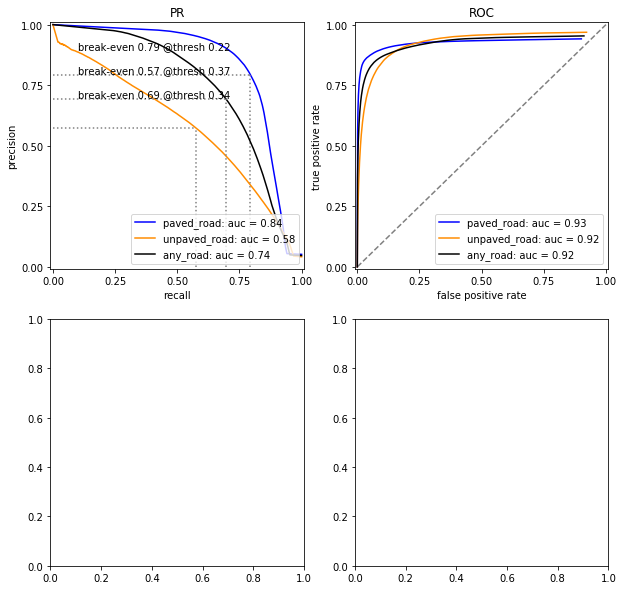

In [12]:
(fpr_dict, 
tpr_dict,
roc_auc_dict, 
precision_dict, 
recall_dict,
pr_auc_dict,
beven_ix_dict,
beven_thresh_dict,
reduced_class_dict) = multiclass_roc_pr(arr_y, arr_yscore, class_dict=class_dict)

# set up summary figure
fig_sum, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_pr(recall_dict, precision_dict, pr_auc_dict, beven_ix_dict, beven_thresh_dict, axs[0, 0])
plot_roc(fpr_dict, tpr_dict, roc_auc_dict, axs[0, 1])

# save figure?
if format_figures is not None:
    plt.savefig(os.path.join(dir_figures, base_fig_name + '_summary' + '.' + format_figures), orientation='portrait')

plt.show()

In [13]:
file_list_selected = ["20180419_074324_0c43_3B_0086.tif", "20180504_094435_0e19_3B_0472.tif"]

### Show individual samples

In [17]:
# prepare index for showing samples
if mode_sample_choice is None:
    samples_ix = [ix for ix, fn in enumerate(file_list_x[:num_x_use]) if fn in file_list_selected]
    if not len(samples_ix):
        raise Exception("none of the tiles selected for individual plotting is among the tiles analyzed")
else:
    samples_ix = utils.gen_sample_index(num_x_use, num_x_show, mode_sample_choice=mode_sample_choice, metric=arr_metric)

{'paved_road': 0.21704696, 'unpaved_road': 0.36934796, 'any_road': 0.3354223}
plotting scale


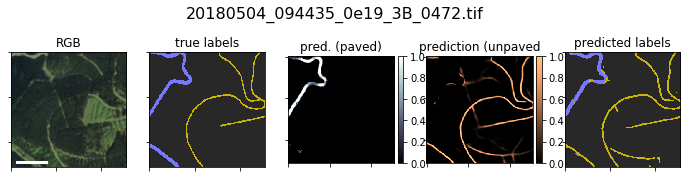

{'paved_road': 0.21704696, 'unpaved_road': 0.36934796, 'any_road': 0.3354223}
plotting scale


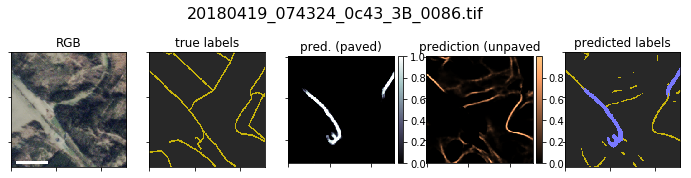

In [18]:
for ix in samples_ix:
    fn = file_list_x[ix]
    # read sat image tile
    x = io.imread(os.path.join(dir_eval, dir_x, fn))
    # retrieve true labels
    y = arr_y[ix*img_size:(ix+1)*img_size].reshape(target_size + (1,), order = 'C')
    # retrieve y score (prediction)
    yscore = arr_yscore[ix*img_size:(ix+1)*img_size, :].reshape(target_size + (dim_yscore,), order = 'C')
    # generate predicted labels from yscore using threshold at breakeven point
    ypred = predict_labels(yscore, beven_thresh_dict, reduced_class_dict)
    print(beven_thresh_dict)
    # show summary plot
    fig_sample = show_sample_prediction(x, y, yscore, ypred, class_dict, 
                                        scale=pixels_per_meter, 
                                        title=fn, 
                                        display_mode=samples_display_mode)
    # save figure?
    if format_figures is not None:
        plt.savefig(os.path.join(dir_figures, base_fig_name + '_' + fn + '.' + format_figures), orientation='portrait')
    plt.show()
    
    # save predicted labels (not yet fleshed out)
    if False and (not model_is_binary):
        # convert true labels to rgb 
        y_rgb = grayscale_to_rgb(y, CLASS_PLOT_PROP, class_dict)
        # convert predicted labels to rgb
        ypred_rgb = grayscale_to_rgb(ypred, CLASS_PLOT_PROP, class_dict)
        # §§ save both true and predicted labels to rgb file
    else:
        # §§ save only predicted labels to file
        pass


In [58]:
CLASS_PLOT_PROP

{'no_img': ['black', 'gray', array([[[0, 0, 0]]], dtype=uint8)],
 'no_road': ['gray', 'gray', array([[[40, 40, 40]]], dtype=uint8)],
 'paved_road': ['blue', 'bone', array([[[120, 120, 255]]], dtype=uint8)],
 'any_road': ['black', 'gnuplot', array([[[200, 200, 200]]], dtype=uint8)],
 'unpaved_road': ['darkorange',
  'copper',
  array([[[200, 180,  10]]], dtype=uint8)]}

In [22]:
# halt
sys.exit()

SystemExit: 

/home/lisa/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
